In [2]:
import io
import os
import pandas as pd
import numpy as np
import json
import pickle
import random
# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types
from google.oauth2 import service_account
from IPython.display import Image
import io
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm

## GCP Credentials

In [3]:
credentials = service_account.Credentials.from_service_account_file('../Google_Credentials/Cred.json')

In [4]:
# Instantiates a client
client = vision.ImageAnnotatorClient(credentials=credentials)

### Retrieve all the cities

In [4]:
#!/usr/bin/env python
#from __future__ import print_function
#import os
list_cities_dir = list()
path = '/mnt/sdb/adadoun/PhD/google-images-download/google_images_download/downloads'
files = os.listdir(path)
for name in files:
    if name != '.ipynb_checkpoints':
        list_cities_dir.append(name)

In [5]:
list_im_cities_dir = list()
path = '/mnt/sdb/adadoun/PhD/google-images-download/google_images_download/downloads/' + list_cities_dir[1]
files = os.listdir(path)
for name in files:
    list_im_cities_dir.append(name)

In [ ]:
dict_cities = dict()
for i, city in enumerate(list_cities_dir):
    list_im_cities_dir = list()
    path = '/mnt/sdb/adadoun/PhD/google-images-download/google_images_download/downloads/' + city
    city_name_l = city.split("_")
    city_name = " ".join(city_name_l[0:len(city_name_l)-1])
    print(city_name)
    files = os.listdir(path)
    for name in files:
        list_im_cities_dir.append(name)
    dict_city = dict()
    list_labels = list()
    list_web_entities = list()
    for city_im in list_im_cities_dir:
        # The name of the image file to annotate
        file_name = path + '/' + city_im
        try:
            Image(file_name, width=400, height=400)
            # Loads the image into memory
            with io.open(file_name, 'rb') as image_file:
                content = image_file.read()

            image = types.Image(content=content)

            # Performs label detection on the image file
            Labels = client.label_detection(image=image).label_annotations
            Web_annotations = client.web_detection(image=image).web_detection.web_entities
            ##
            for label in Labels:
                des = label.description
                if len(des) > 0:
                    list_labels.append(des)
            dict_web_entities = dict()
            for web_annot in Web_annotations:
                des = web_annot.description
                if len(des) > 0:
                    list_web_entities.append(des)
        except:
            print("An exception occurred") 
    dict_city['Labels'] = list_labels
    dict_city['Web_Entities'] = list_web_entities
    dict_cities[city_name] = dict_city

Labuan
An exception occurred
An exception occurred
Medan
An exception occurred
An exception occurred
An exception occurred
An exception occurred
Tokyo
Moscow
Dubai
An exception occurred
An exception occurred
Bengaluru
An exception occurred
An exception occurred
An exception occurred
Doha
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
Kuantan
An exception occurred
An exception occurred
An exception occurred
An exception occurred
Marudi
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
Aberdeen
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
An exception occurred
Frankfurt am Main
An exception occurred
An exception occurred
An exception occurred
Phuket
An exception occurred
Bandar Seri Begawan
An exception occurred
Paris


In [14]:
with open('Cities_Key_Word.json', 'w') as fp:
    json.dump(dict_cities, fp, sort_keys=True, indent=4)

### Load the dict_json

In [6]:
with open('Cities_Key_Word_.json', 'r') as f:
    dict_json = json.load(f)

### Load fastext word vectors

In [5]:
def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

In [ ]:
fasttext = load_vectors('crawl-300d-2M.vec')

In [ ]:
dict_fasttext = dict()
for key in fasttext:
    dict_fasttext[key] = np.array(list(fasttext[key]))

## Build the corpus

In [34]:
corpus = list()
for key in dict_json:
    city_content = list()
    labels_list = dict_json[key]['Labels']
    web_entities_list = dict_json[key]['Web_Entities']
    for x in labels_list:
        city_content.append(x)
    for x in web_entities_list:
        city_content.append(x)
    corpus.append(" ".join(city_content))

## Load fasttext words

In [6]:
with open('../data/fastext_dictionary.pkl', 'rb') as f:
    dict_fasttext = pickle.load(f)

## Tf_idf_vectorizer

In [7]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

NameError: name 'corpus' is not defined

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
dict_idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

In [88]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
dict_idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
with open('dict_idf.pkl', 'wb') as f:
    pickle.dump(dict_idf, f, pickle.HIGHEST_PROTOCOL)

In [37]:
%%time
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
dict_idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
with open('dict_idf.pkl', 'wb') as f:
    pickle.dump(dict_idf, f, pickle.HIGHEST_PROTOCOL)
city2vec = list()
for i, item in enumerate(corpus):
    item = item.split()
    w_array = np.zeros(300)
    k_words = 0
    for k in range(len(item)):
        if item[k] in dict_fasttext:
            w = dict_fasttext[item[k]]
            if len(w) > 0 and item[k] in dict_idf :
                k_words += 1 
                w = dict_idf[item[k]]*w
                w_array += w
    w_array = w_array/k_words
    city2vec.append(w_array)
fasttext_cities = np.array(city2vec)

CPU times: user 348 ms, sys: 0 ns, total: 348 ms
Wall time: 349 ms


In [38]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
dict_idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
with open('dict_idf.pkl', 'wb') as f:
    pickle.dump(dict_idf, f, pickle.HIGHEST_PROTOCOL)
city2vec = list()
for i, item in enumerate(corpus):
    item = item.split()
    w_array = np.zeros(300)
    k_words = 0
    for k in range(len(item)):
        if item[k] in dict_fasttext:
            w = dict_fasttext[item[k]]
            if len(w) > 0 and item[k] in dict_idf :
                k_words += 1 
                w = dict_idf[item[k]]*w
                w_array += w
    w_array = w_array/k_words
    city2vec.append(w_array)
fasttext_cities = np.array(city2vec)
dict_fastext_cities_key_words = dict()
k = 0
for key in dict_json:
    dict_fastext_cities_key_words[key] = fasttext_cities[k,:]
    k += 1

In [39]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
dict_idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
with open('dict_idf.pkl', 'wb') as f:
    pickle.dump(dict_idf, f, pickle.HIGHEST_PROTOCOL)
city2vec = list()
for i, item in enumerate(corpus):
    item = item.split()
    w_array = np.zeros(300)
    k_words = 0
    for k in range(len(item)):
        if item[k] in dict_fasttext:
            w = dict_fasttext[item[k]]
            if len(w) > 0 and item[k] in dict_idf :
                k_words += 1 
                w = dict_idf[item[k]]*w
                w_array += w
    w_array = w_array/k_words
    city2vec.append(w_array)
fasttext_cities = np.array(city2vec)
dict_fastext_cities_key_words = dict()
k = 0
for key in dict_json:
    dict_fastext_cities_key_words[key] = fasttext_cities[k,:]
    k += 1
with open('fastext_cities.pkl', 'wb') as f:
    pickle.dump(dict_fastext_cities_key_words, f, pickle.HIGHEST_PROTOCOL)

In [8]:
with open('../data/dict_idf.pkl', 'rb') as f:
    dict_idf = pickle.load(f)

## Load cities fasttext dict

In [11]:
with open('../data/fastext_cities.pkl', 'rb') as f:
    dict_fastext_cities_key_words = pickle.load(f)

## Now let's try it 

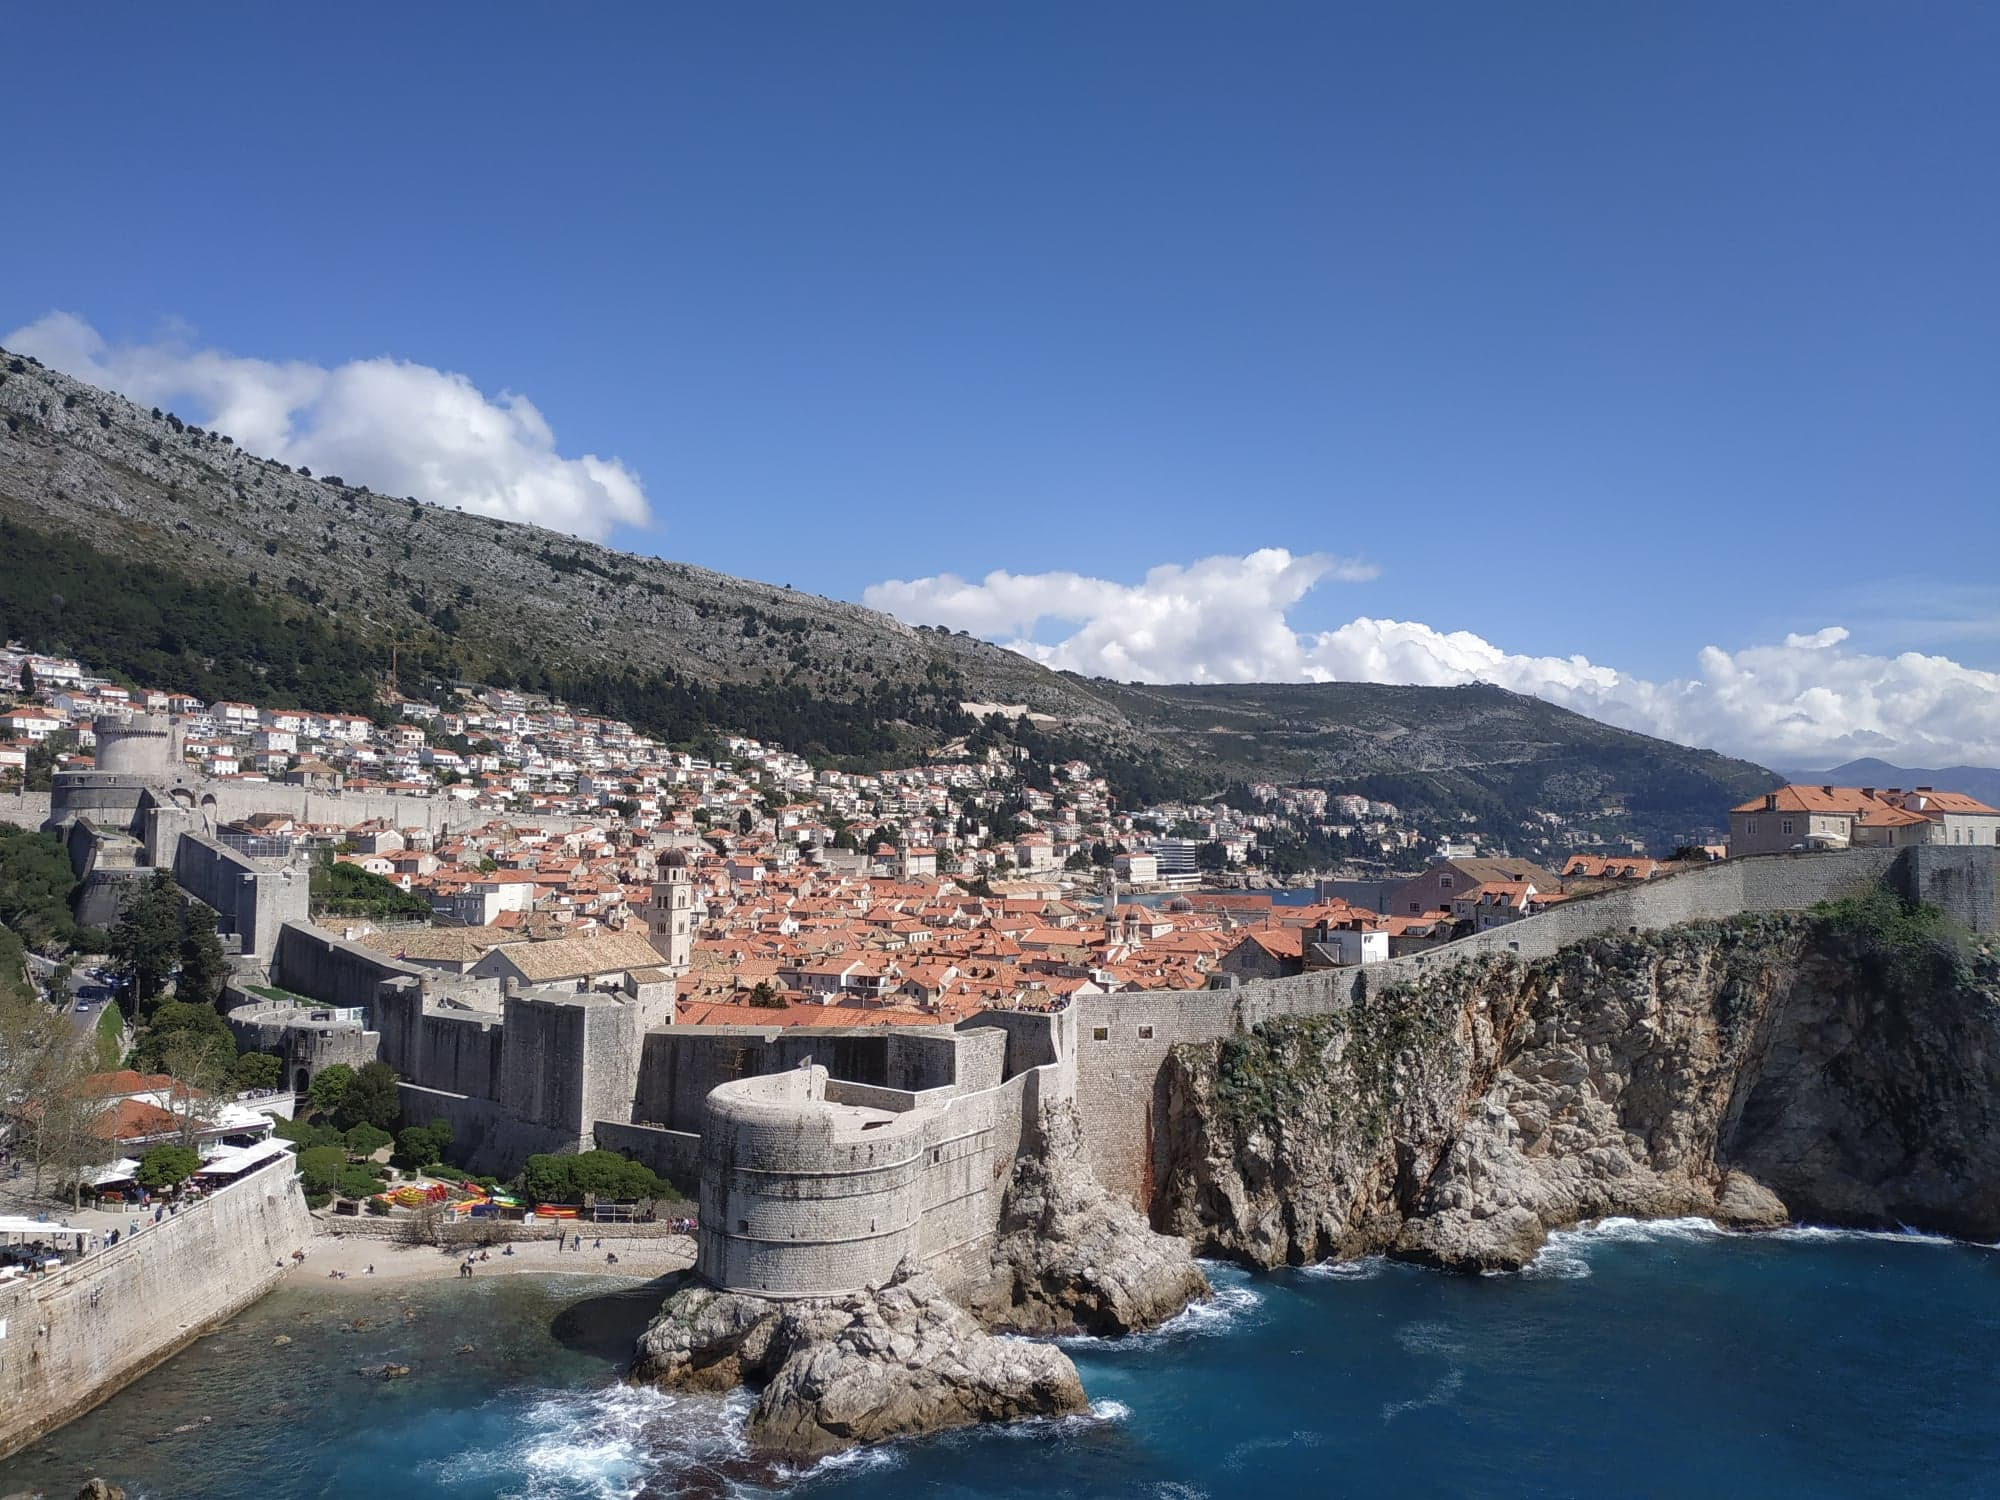

In [13]:
# The name of the image file to annotate
file_name = '../data/Kings_Landing.jpg'
Image(file_name, width=400, height=400)

In [16]:
list_labels = list()
list_web_entities = list()
city_content = list()
with io.open(file_name, 'rb') as image_file:
    content = image_file.read()

image = types.Image(content=content)

# Performs label detection on the image file
Labels = client.label_detection(image=image).label_annotations
Web_annotations = client.web_detection(image=image).web_detection.web_entities
##
for label in Labels:
    des = label.description
    if len(des) > 0:
        list_labels.append(des)
dict_web_entities = dict()
for web_annot in Web_annotations:
    des = web_annot.description
    if len(des) > 0:
        list_web_entities.append(des)
for x in list_labels:
    city_content.append(x)
for x in list_web_entities:
    city_content.append(x)
corpus_kings_landing = " ".join(city_content)

In [17]:
corpus_kings_landing

'Mountain Sky Mountainous landforms Water Town Village Wilderness Tourism Human settlement Water resources Old City of Dubrovnik Lokrum Lovrijenac Gruž Crociera Travel Plitvička jezera Budapest, including the Banks of the Danube, the Buda Castle Quarter and Andrássy Avenue Tourist attraction'

In [18]:
item = corpus_kings_landing.split()
w_array = np.zeros(300)
k_words = 0
for k in range(len(item)):
    if item[k] in dict_fasttext:
        w = dict_fasttext[item[k]]
        if len(w) > 0 and item[k] in dict_idf :
            k_words += 1 
            w = dict_idf[item[k]]*w
            w_array += w
w_array = w_array/k_words
kings_landing_fastext_vectors  = w_array.reshape((1,-1))

In [19]:
kings_landing_fastext_vectors.shape

(1, 300)

In [20]:
dict_sim = dict()
for key in dict_fastext_cities_key_words:
    a = kings_landing_fastext_vectors
    b = dict_fastext_cities_key_words[key].reshape((1,-1))
    dict_sim[key] = norm(a-b)

In [55]:
dict_sim = dict()
for key in dict_fastext_cities_key_words:
    a = kings_landing_fastext_vectors
    b = dict_fastext_cities_key_words[key].reshape((1,-1))
    dict_sim[key] = norm(a-b)
sorted_dict_sim = sorted(dict_sim.items(), key=operator.itemgetter(1))
print("We recommend you to go to :")
k = 0
for i in sorted_dict_sim:
    print(i[0])
    # The name of the image file to annotate
    k += 1
    if k>5:
        break

In [57]:
print("We recommend you to go to :")
k = 0
for i in sorted_dict_sim:
    print(i[0])
    # The name of the image file to annotate
    k += 1
    if k>5:
        break

We recommend you to go to :
Ko Samui Island
Labuan
Cape Town
Kota Kinabalu
Stavanger
Male


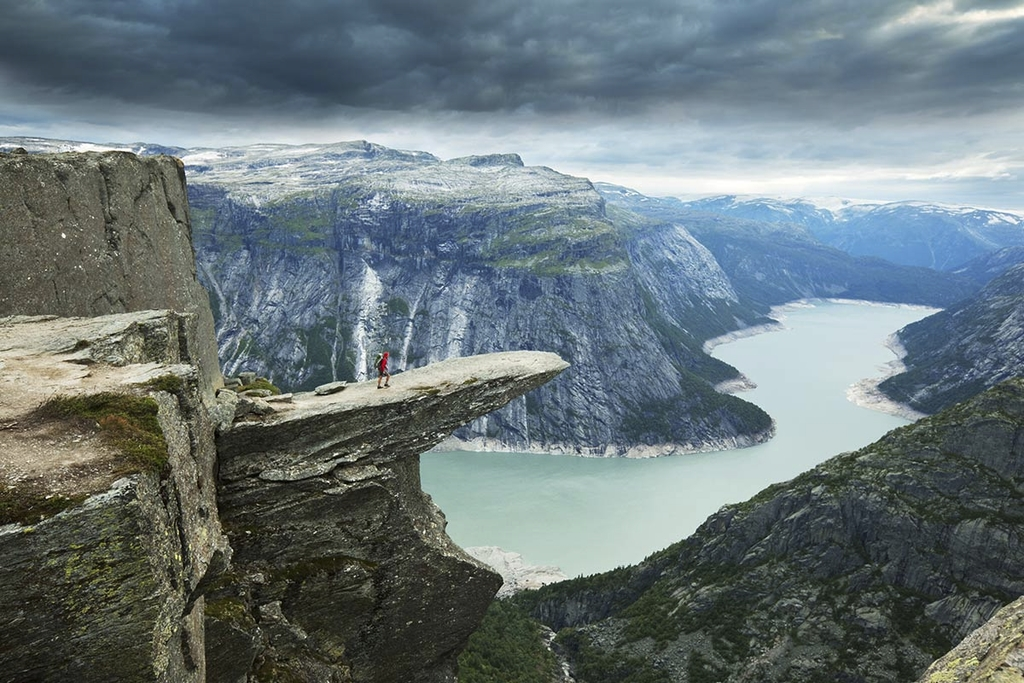

In [58]:
file_name = '/mnt/sdb/adadoun/PhD/google-images-download/google_images_download/downloads/' + 'Stavanger' + str('_images') + '/28. stavanger.jpg'
Image(file_name, width=400, height=400)

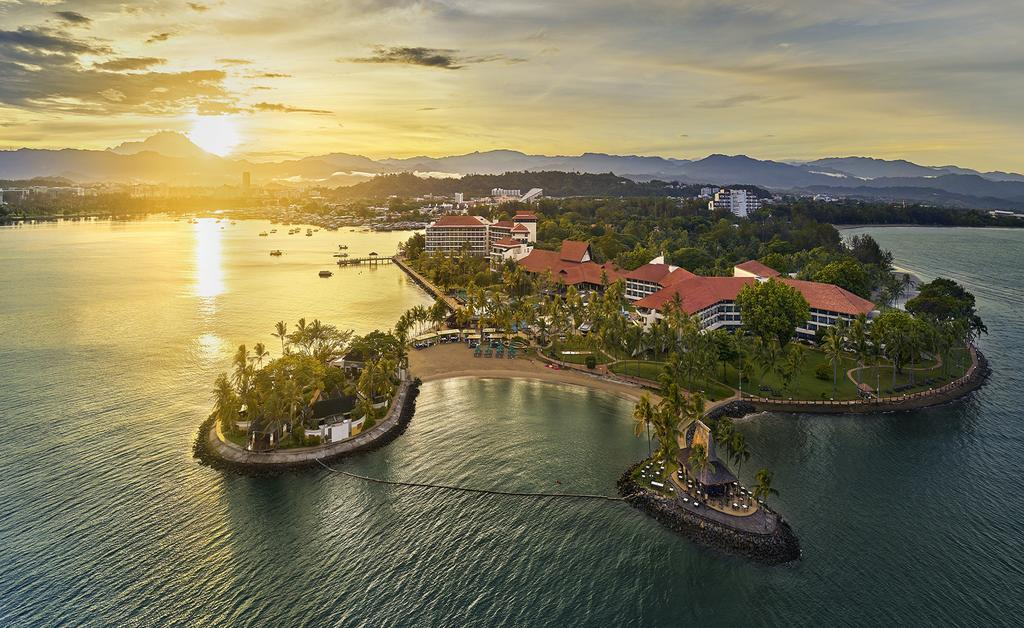

In [59]:
file_name = '/mnt/sdb/adadoun/PhD/google-images-download/google_images_download/downloads/' + 'Kota_Kinabalu' + str('_images') + '/98. 159821367.jpg'
Image(file_name, width=400, height=400)

## What about if I take an image of a city: SF bridge

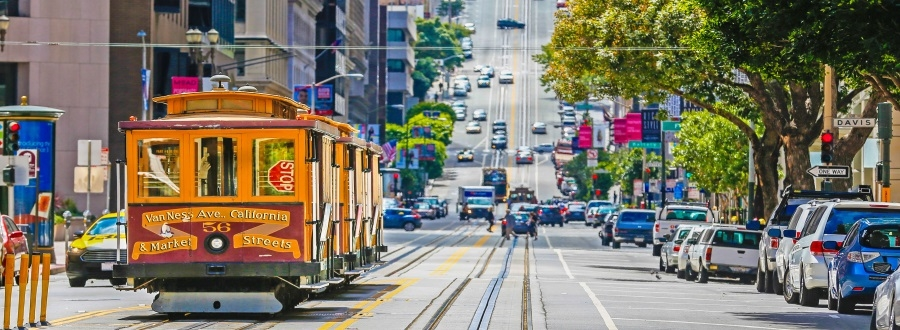

In [60]:
# The name of the image file to annotate
file_name = '/mnt/sdb/adadoun/PhD/google-images-download/google_images_download/downloads/San_Francisco_images/59. 293106_900x330.jpg'
Image(file_name, width=400, height=400)

In [61]:
list_labels = list()
list_web_entities = list()
city_content = list()
with io.open(file_name, 'rb') as image_file:
    content = image_file.read()

image = types.Image(content=content)

# Performs label detection on the image file
Labels = client.label_detection(image=image).label_annotations
Web_annotations = client.web_detection(image=image).web_detection.web_entities
##
for label in Labels:
    des = label.description
    if len(des) > 0:
        list_labels.append(des)
dict_web_entities = dict()
for web_annot in Web_annotations:
    des = web_annot.description
    if len(des) > 0:
        list_web_entities.append(des)
for x in list_labels:
    city_content.append(x)
for x in list_web_entities:
    city_content.append(x)
corpus_SF = " ".join(city_content)

In [62]:
corpus_SF

'Transport Mode of transport Vehicle Cable car Tram Thoroughfare Public transport Street Urban area Neighbourhood Union Square Financial District PIER 39 Golden Gate Bridge Hotel Exploratorium Los Angeles City Tourist attraction Vacation rental'

In [63]:
item = corpus_SF.split()
w_array = np.zeros(300)
k_words = 0
for k in range(len(item)):
    if item[k] in dict_fasttext:
        w = dict_fasttext[item[k]]
        if len(w) > 0 and item[k] in dict_idf :
            k_words += 1 
            w = dict_idf[item[k]]*w
            w_array += w
w_array = w_array/k_words
SF_fastext_vectors  = w_array.reshape((1,-1))

In [64]:
dict_sim = dict()
for key in dict_fastext_cities_key_words:
    a = SF_fastext_vectors
    b = dict_fastext_cities_key_words[key].reshape((1,-1))
    dict_sim[key] = norm(a-b)

In [65]:
import operator
sorted_dict_sim = sorted(dict_sim.items(), key=operator.itemgetter(1))

In [66]:
print("We recommend you to go to :")
k = 0
for i in sorted_dict_sim:
    print(i[0])
    # The name of the image file to annotate
    k += 1
    if k>5:
        break

We recommend you to go to :
Amsterdam
New Orleans
London
Nagoya
George Town
Bengaluru


## Evaluate our model on tr data

In [82]:
dict_rank_list = dict()
dict_eval_tr_cities = dict()
for i, city in enumerate(list_cities_dir):
    list_im_cities_dir = list()
    path = '/mnt/sdb/adadoun/PhD/google-images-download/google_images_download/downloads/' + city
    city_name_l = city.split("_")
    city_name = " ".join(city_name_l[0:len(city_name_l)-1])
    print(city_name)
    files = os.listdir(path)
    for name in files:
        list_im_cities_dir.append(name)
    list_labels = list()
    for city_im in list_im_cities_dir:
        if random.randint(0,20) == 20: 
            # The name of the image file to annotate
            file_name = path + '/' + city_im
            try:
                Image(file_name, width=400, height=400)
                # Loads the image into memory
                with io.open(file_name, 'rb') as image_file:
                    content = image_file.read()

                image = types.Image(content=content)

                # Performs label detection on the image file
                Labels = client.label_detection(image=image).label_annotations
                Web_annotations = client.web_detection(image=image).web_detection.web_entities
                ##
                list_labels = list()
                for label in Labels:
                    des = label.description
                    if len(des) > 0:
                        list_labels.append(des)
                for web_annot in Web_annotations:
                    des = web_annot.description
                    if len(des) > 0:
                        list_labels.append(des)
                corpus_city = " ".join(list_labels)
                item = corpus_city.split()
                w_array = np.zeros(300)
                k_words = 0
                for k in range(len(item)):
                    if item[k] in dict_fasttext:
                        w = dict_fasttext[item[k]]
                        if len(w) > 0 and item[k] in dict_idf :
                            k_words += 1 
                            w = dict_idf[item[k]]*w
                            w_array += w
                w_array = w_array/k_words
                city_fastext_vectors  = w_array.reshape((1,-1))
                dict_sim = dict()
                for key in dict_fastext_cities_key_words:
                    a = city_fastext_vectors
                    b = dict_fastext_cities_key_words[key].reshape((1,-1))
                    dict_sim[key] = norm(a-b)
                sorted_dict_sim = sorted(dict_sim.items(), key=operator.itemgetter(1))
                k = 0
                for i in sorted_dict_sim:
                    # The name of the image file to annotate
                    k += 1
                    if i[0] == city_name:
                        if city_name in dict_rank_list:
                            list_appended = dict_rank_list[city_name]
                            list_appended.append(k)
                            dict_rank_list[city_name] = list_appended
                        else:
                            dict_rank_list[city_name] = [k]
                        break
            except:
                print("An exception occurred") 

Labuan
Medan
Tokyo
Moscow
Dubai
An exception occurred
Bengaluru
Doha
An exception occurred
An exception occurred
Kuantan
Marudi


/mnt/sdb/adadoun/PhD/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in true_divide


Aberdeen
An exception occurred
Frankfurt am Main
An exception occurred
Phuket
Bandar Seri Begawan
Paris
Lahad Datu
Denpasar
Shanghai
Delhi
Republic of Mauritius
Beijing
Milan
Da Nang
Kota Kinabalu
Gunung Mulu National Park
Manila
Changle District
Fukuoka
Houston
An exception occurred
Long Akah
Istanbul
Colombo
An exception occurred
An exception occurred
Stavanger
Vancouver
Auckland
Sibu
Johor Bahru
Surabaya
Haikou
An exception occurred
An exception occurred
Ba Kelalan
Singapore
Ipoh
George Town
Düsseldorf
Stockholm
Ho Chi Minh City
Jiangbei District
Cebu City
Seoul
An exception occurred
Limbang
Hyderabad
Yangon
Miri
Dhaka
Yogyakarta
An exception occurred
Sapporo
New Orleans
Christchurch
Johannesburg
Perth
Bintulu
Nanjing
Zürich
Long Banga
Hong Kong
Kuala Lumpur
An exception occurred
Seattle
Guangzhou
Tanjung Manis Airport
Siem Reap
Bangkok
Cape Town
Kunming
Ko Samui Island
Kathmandu
Sandakan
An exception occurred
Long Seridan
An exception occurred
Chennai
An exception occurred
Amsterda

In [83]:
ranks_array = list()
for key in dict_rank_list:
    for el in dict_rank_list[key]:
        ranks_array.append(el)
mean_rank = np.mean(ranks_array)

In [85]:
mean_rank

27.986792452830187